In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime

In [81]:
DATA_PATH = "ClimateData/"
country_df = pd.read_csv(DATA_PATH + "GlobalLandTemperaturesByCountry.csv")
city_df = pd.read_csv(DATA_PATH + "GlobalLandTemperaturesByCity.csv")
state_df = pd.read_csv(DATA_PATH + "GlobalLandTemperaturesByState.csv")
global_df = pd.read_csv(DATA_PATH + "GlobalTemperatures.csv")

In [82]:
# Remove specific completely missing regions
country_df = country_df[country_df["Country"] != "Antarctica"]

In [83]:
# Perhaps a visual of the data quality before cleaning

# Perhaps a visual of a regions temperatures before cleaning

In [132]:
def clean_and_impute(df, region_column, temp_column='AverageTemperature', uncert_column="AverageTemperatureUncertainty", seasonal_period=4):
    """
    Clean and impute missing data in a DataFrame for each region.
    
    Parameters:
    - df: The DataFrame to process
    - region_column: The column name specifying the location granularity
    - column: The column name of the temperature data
    - seasonal_period: The seasonal period for the SARIMAX model
    
    Returns:
    - The processed DataFrame with missing data imputed
    """
    def impute_missing_data(tempseries, seasonal_period):
        # Fit SARIMAX model
        model = SARIMAX(tempseries, seasonal_order=(5, 1, 0, seasonal_period), enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        
        # Get predicted values (fitted values)
        predicted = results.predict(start=tempseries.index[0], end=tempseries.index[-1], dynamic=False)
        
        # Impute missing values with predicted values
        tempseries[tempseries.isna()] = predicted[tempseries.isna()]

        return tempseries
    
    def process_group(group):
        print(group.iloc[0], group.iloc[-1])
        # Set the index to datetime for time series processing
        group = group.set_index('dt')
        group.index.freq = "MS"
        
        # Drop rows with missing values at the start and end
        group = group.loc[group[temp_column].first_valid_index():group[temp_column].last_valid_index()]
        
        # Apply imputation
        group[temp_column] = impute_missing_data(group[temp_column], seasonal_period)

        # Forward fill uncertainties
        group[uncert_column] = group[uncert_column].ffill()
        return group
    
    # Convert dt column to datetime
    df['dt'] = pd.to_datetime(df['dt'])
    
    # Apply the cleaning and imputation process to each group
    if region_column:
        df = df.groupby(region_column).apply(process_group, include_groups=False).reset_index()

    else:
        # If no grouping is issued, make group of entire dataframe
        df = df.groupby([1]*len(df)).apply(process_group).reset_index()
        df = df.drop("level_0", axis=1)
    return df


In [ ]:
# Apply the cleaning and imputation process to Country DataFrame, then store to csv
country_df = clean_and_impute(country_df, "Country")
country_df.to_csv("TemperatureByCountry.csv",  float_format='%.3f', index=False, date_format='%Y-%m-%d')

In [127]:
# Apply the cleaning and imputation process to Global DataFrame, then store to csv
global_df = clean_and_impute(global_df, None, temp_column="LandAverageTemperature", uncert_column="LandAverageTemperatureUncertainty")
global_df = clean_and_impute(global_df, None, temp_column="LandAndOceanAverageTemperature", uncert_column="LandAndOceanAverageTemperatureUncertainty")
global_df = clean_and_impute(global_df, None, temp_column="LandMaxTemperature", uncert_column="LandMaxTemperatureUncertainty")
global_df = clean_and_impute(global_df, None, temp_column="LandMinTemperature", uncert_column="LandMinTemperatureUncertainty")
global_df.to_csv("TemperatureByWorld.csv", float_format='%.3f', index=False, date_format='%Y-%m-%d')

In [ ]:
# Apply the cleaning and imputation process to State DataFrame, then store to csv
state_df = clean_and_impute(state_df, "State")
state_df.to_csv("TemperatureByState.csv", float_format='%.3f', index=False, date_format='%Y-%m-%d')

In [ ]:
# Apply the cleaning and imputation process to City DataFrame, then store to csv
city_df = clean_and_impute(city_df, ["City", "Country", "Latitude", "Longitude"])
city_df.to_csv("TemperatureByCity.csv", float_format='%.3f', index=False, date_format='%Y-%m-%d')

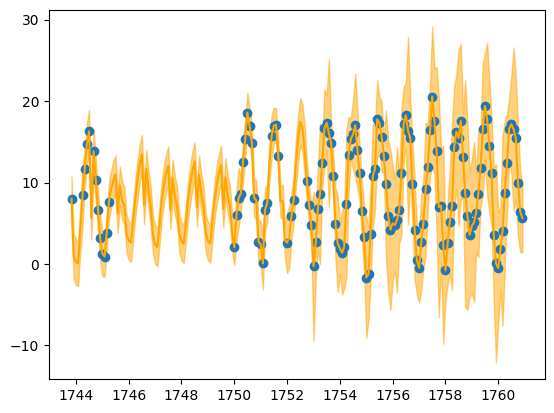

In [135]:
# Imputed data overlapped on previous data
dirty_country_df = pd.read_csv(DATA_PATH + "GlobalLandTemperaturesByCountry.csv")
dirty_country_df['dt'] = pd.to_datetime(dirty_country_df['dt'])
netherlands_dirty = dirty_country_df[dirty_country_df["Country"] == "Netherlands"]
netherlands_dirty = netherlands_dirty.set_index(netherlands_dirty["dt"])

country_df = pd.read_csv("TemperatureByCountry.csv")
country_df['dt'] = pd.to_datetime(country_df['dt'])
netherlands = country_df[country_df["Country"] == "Netherlands"]
netherlands = netherlands.set_index(netherlands["dt"])

netherlands_dirty = netherlands_dirty.truncate(after="1760-12")
netherlands = netherlands.truncate(after="1760-12")
plt.plot(netherlands_dirty["dt"].dt.date, netherlands_dirty["AverageTemperature"], "o", label="dirty")
plt.plot(netherlands["dt"], netherlands["AverageTemperature"], label="cleaned", color="orange")
plt.fill_between(netherlands["dt"], netherlands["AverageTemperature"]+netherlands["AverageTemperatureUncertainty"], netherlands["AverageTemperature"]-netherlands["AverageTemperatureUncertainty"], color="orange", alpha=0.5)

In [141]:
# Visualize outliers
state_df = pd.read_csv("TemperatureByState.csv")
global_df = pd.read_csv("TemperatureByWorld.csv")
city_df = pd.read_csv("TemperatureByCity.csv")

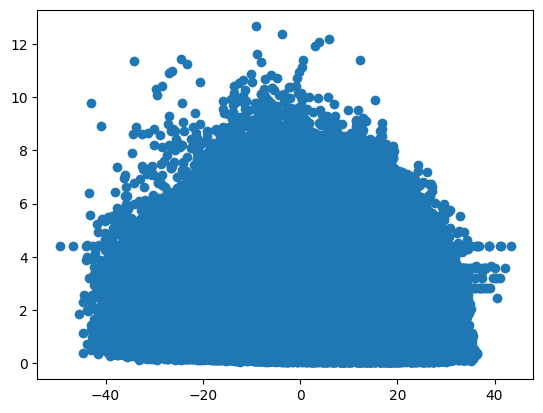

In [203]:
plt.scatter(state_df["AverageTemperature"], state_df["AverageTemperatureUncertainty"])
plt.show()

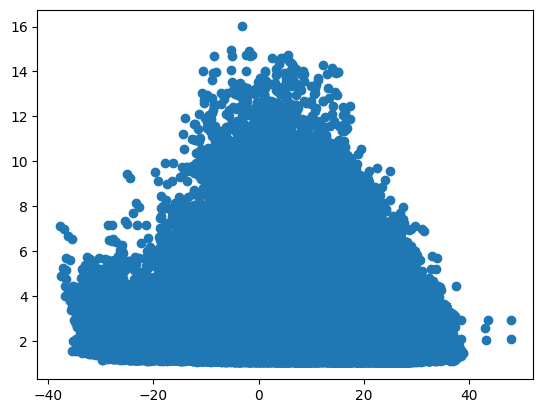

In [204]:
plt.scatter(country_df["AverageTemperature"], country_df["AverageTemperatureUncertainty"])
plt.show()

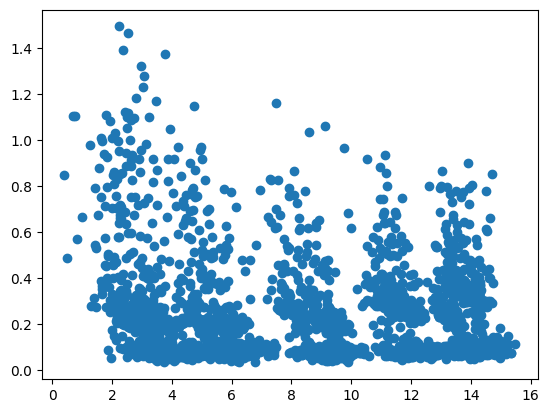

In [144]:
plt.scatter(global_df["LandAverageTemperature"], global_df["LandAverageTemperatureUncertainty"])
plt.show()

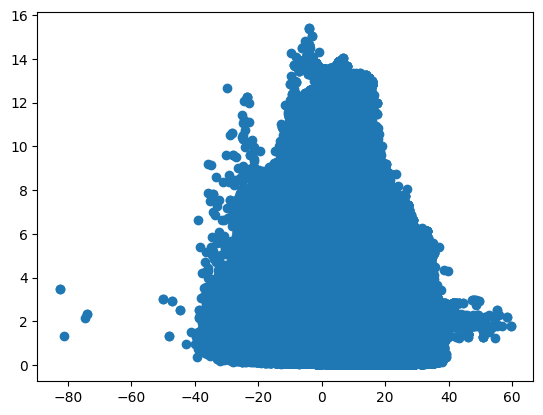

In [196]:
plt.scatter(city_df["AverageTemperature"], city_df["AverageTemperatureUncertainty"])
plt.show()

In [197]:
# Remove all data before outliers of region
state_df['dt'] = pd.to_datetime(state_df['dt'])
state_df = state_df[~((state_df["State"] == "Chukot") & (state_df['dt'].dt.year < 1869))]
state_df = state_df[~((state_df["State"] == "Oklahoma") & (state_df['dt'].dt.year < 1820))]
state_df = state_df[~((state_df["State"] == "Idaho") & (state_df['dt'].dt.date < datetime.date(1826,9,1)))]
state_df = state_df[~((state_df["State"] == "Wyoming") & (state_df['dt'].dt.date < datetime.date(1779,2,1)))]
state_df = state_df[~((state_df["State"] == "Roraima") & (state_df['dt'].dt.date < datetime.date(1826,7,1)))]

In [198]:
country_df['dt'] = pd.to_datetime(country_df['dt'])
country_df = country_df[~((country_df["Country"] == "Colombia" ) & (country_df['dt'].dt.date < datetime.date(1826, 7, 1)))]
country_df = country_df[~((country_df["Country"] == "Gabon" ) & (country_df['dt'].dt.date < datetime.date(1858, 9, 1)))]
country_df = country_df[~((country_df["Country"] == "Canada" ) & (country_df['dt'].dt.date < datetime.date(1811, 8, 1)))]
country_df = country_df[~((country_df["Country"] == "Cameroon" ) & (country_df['dt'].dt.date < datetime.date(1858, 9, 1)))]
country_df = country_df[~((country_df["Country"] == "Kuwait" ) & (country_df['dt'].dt.date < datetime.date(1843, 11, 1)))]
country_df = country_df[~((country_df["Country"] == "North America" ) & (country_df['dt'].dt.year < 1796))]

In [194]:
def remove_data_before_last_outlier(df, temp_column='AverageTemperature', city_column='City', date_column='dt', high_temp=60, low_temp=-90):
    """
    Removes data points for each city that were recorded before the last occurrence of outliers.
    
    Parameters:
    - df: The DataFrame to process
    - temp_column: The column name of the temperature data
    - city_column: The column name of the city data
    - date_column: The column name of the date data
    - high_temp: The threshold above which temperatures are considered outliers
    - low_temp: The threshold below which temperatures are considered outliers
    
    Returns:
    - The processed DataFrame with data points before the last outlier removed for each city
    """
    # Identify outliers
    outliers = df[(df[temp_column] > high_temp) | (df[temp_column] < low_temp)]
    
    # Find the last occurrence of an outlier for each city
    last_outliers = outliers.groupby(city_column)[date_column].max().reset_index()

    # Uniques and total are the same
    print(len(last_outliers["City"].unique()))
    print(last_outliers)
    
    for city, date in last_outliers.itertuples(index=False, name=None):
        df = df[~((df["City"] == city) & (df["dt"].dt.date < (date + pd.DateOffset(months=1)).date()))]
    return df

city_df = remove_data_before_last_outlier(city_df)



118
              City         dt
0            Abuja 1858-08-01
1             Agra 1865-01-01
2            Akure 1858-08-01
3           Aleppo 1808-09-01
4             Amol 1827-09-01
..             ...        ...
113         Weinan 1839-12-01
114       Winnipeg 1811-07-01
115           Xian 1839-12-01
116       Xianyang 1839-12-01
117  Yekaterinburg 1808-09-01

[118 rows x 2 columns]
       City Country Latitude Longitude         dt  AverageTemperature  \
0  A Coruña   Spain   42.59N     8.73W 1743-11-01              10.779   
1  A Coruña   Spain   42.59N     8.73W 1743-12-01               1.172   
2  A Coruña   Spain   42.59N     8.73W 1744-01-01               0.255   
3  A Coruña   Spain   42.59N     8.73W 1744-02-01               0.055   
4  A Coruña   Spain   42.59N     8.73W 1744-03-01               5.315   

   AverageTemperatureUncertainty  
0                          1.942  
1                          1.942  
2                          1.942  
3                          1.942 

In [202]:
# Write newly cleaned files again to csv
state_df.to_csv("TemperatureByCity.csv", float_format='%.3f', index=False, date_format='%Y-%m-%d')
country_df.to_csv("TemperatureByCountry.csv",  float_format='%.3f', index=False, date_format='%Y-%m-%d')
city_df.to_csv("TemperatureByCity.csv",  float_format='%.3f', index=False, date_format='%Y-%m-%d')